<div class="alert alert-block alert-warning">
<b>Disclaimer:</b> The main objective of the jupyter notebooks is to show how to use the models of the <i>QENS library</i> by
    
- building a fitting model: composition of models, convolution with a resolution function
- setting and run the fit   
- extracting and displaying information about the results

These steps have a minimizer-dependent syntax. That's one of the reasons why different minimizers have been used in the notebooks provided as examples.
But, the initial guessed parameters might not be optimal, resulting in a poor fit of the reference data.
</div>


<h1> Example: Water Teixeira model convoluted with resolution function and fitted with bumps </h1>

<a id='Table of Contents'></a><h1>Table of Contents</h1>

- <a href='#introduction'>Introduction</a> 
- <a href='#imports'>Import and install required libraries</a>  
- <a href='#set_fitting'>Setting of fitting</a>  
- <a href='#run_fit'>Running the fit</a>  
- <a href='#results'>Showing the results</a> 

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use the <b>water_teixeira</b> model and fit the data using bumps.
</div>

The data are two sets of water data measured at IN5 (ILL) using two different wavelengths, 5 and 8 &#x212B;.

**Reference:** J. Qvist, H. Schober and B. Halle, *J. Chem. Phys.* **134**, 144508 (2011)

### Physical units
For information about unit conversion, please refer to the jupyter notebook called `Convert_units.ipynb` in the `tools` folder.

The dictionary of units defined in the cell below specify the units of the refined parameters adapted to the convention used in the experimental datafile.

In [1]:
# Units of parameters for selected QENS model and experimental data
dict_physical_units = {'omega': "1/ps", 
                       'q': "1/Angstrom", 
                       'scale': "unit_of_signal/ps", 
                       'center': "1/ps", 
                       'D': "Angstrom^2/ps", 
                       'radius': "Angstrom", 
                       'resTime': "ps"}

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [2]:
# Imported required libraries
from __future__ import print_function
import sys
import os

%matplotlib inline

# for interactive plots
import panel
panel.extension()
import panel.widgets as pnw

# the following two lines are to remove the warning about too many figures open simultaneously
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 0})

In [3]:
# install bumps (if not already installed)
import pkgutil
if not pkgutil.find_loader("bumps"):
    bumpsY = pnw.Button(name='Yes', button_type='success')
    bumpsN = pnw.Button(name='No', button_type='danger')
    choice_installation = panel.Column("Do you want to install bumps?", panel.Row(bumpsY, bumpsN))
    display(choice_installation)

In [4]:
if not pkgutil.find_loader("bumps"):
    if bumpsY.clicks>0:
        !{sys.executable} -m pip install bumps
    elif bumpsN.clicks>0:
        print("You will not be able to run some of the remaining parts of this notebook")

In [5]:
import bumps

In [6]:
# check version of bumps installed
# Information message if installed version not recent enough
from distutils.version import StrictVersion
if StrictVersion(bumps.__version__) <= StrictVersion('0.7.6'):
    print("""The version of bumps installed is not recent 
    enough to run the examples. 
    Please update bumps. The minimum version required is 0.7.8""")

 (<a href='#Table of Contents'>Top</a>)<a id='set_fitting'></a><h2>Setting of fitting </h2>
<h3> install QENSmodels (if not already installed) </h3>

In [7]:
if not pkgutil.find_loader("QENSmodels"):
    buttonY = pnw.Button(name='Yes', button_type='success')
    buttonN = pnw.Button(name='No', button_type='danger')
    choice_installation = panel.Column("Do you want to install the QENSmodels' library?", panel.Row(buttonY, buttonN))
    display(choice_installation)

In [8]:
if not pkgutil.find_loader("QENSmodels"):
    if buttonY.clicks>0:
        !{sys.executable} -m pip install git+https://github.com/QENSlibrary/QENSmodels#egg=QENSmodels
    elif buttonN.clicks>0:
        print("You will not be able to run some of the remaining parts of this notebook")

<h3> import reference data </h3>

In [9]:
import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty

path_to_data = './data/'

# Data
# Wavelength 5 Angstrom
with h5py.File(path_to_data + 'H2O_293K_5A.hdf', 'r') as f:
    hw_5A = f['entry1']['data1']['X'][:]
    q_5A = f['entry1']['data1']['Y'][:]
    unit_w5A = f['entry1']['data1']['X'].attrs['long_name']
    unit_q5A = f['entry1']['data1']['Y'].attrs['long_name']
    sqw_5A = np.transpose(f['entry1']['data1']['DATA'][:])
    err_5A = np.transpose(f['entry1']['data1']['errors'][:])


# Wavelength 8 Angstrom
with h5py.File(path_to_data + 'H2O_293K_8A.hdf', 'r') as f:
    hw_8A = f['entry1']['data1']['X'][:]
    q_8A = f['entry1']['data1']['Y'][:]
    unit_w8A = f['entry1']['data1']['X'].attrs['long_name']
    unit_q8A = f['entry1']['data1']['Y'].attrs['long_name']
    sqw_8A = np.transpose(f['entry1']['data1']['DATA'][:])
    err_8A = np.transpose(f['entry1']['data1']['errors'][:])

# Resolution
# Wavelength 5 Angstrom
with h5py.File(path_to_data + 'V_273K_5A.hdf', 'r') as f:
    res_5A = np.transpose(f['entry1']['data1']['DATA'][:])

# Wavelength 8 Angstrom
with h5py.File(path_to_data + 'V_273K_8A.hdf', 'r') as f:
    res_8A = np.transpose(f['entry1']['data1']['DATA'][:])

# Force resolution function to have unit area
# 5 Angstrom
for i in range(len(q_5A)):
    area = simps(res_5A[:,i], hw_5A)
    res_5A[:,i] /= area 
    
# 8 Angstrom
for i in range(len(q_8A)):
    area = simps(res_8A[:,i], hw_8A)
    res_8A[:,i] /= area
    
# Fit range -1 to +1 meV
idx_5A = np.where(np.logical_and(hw_5A > -1.0, hw_5A < 1.0))
idx_8A = np.where(np.logical_and(hw_8A > -1.0, hw_8A < 1.0))

def model_convol(x, q, scale=1, center=0, D=1, resTime=1, radius=1, DR=1, resolution=None):
    model = QENSmodels.sqwWaterTeixeira(x, q, scale, center, D, resTime, radius, DR)
    return np.convolve(model, resolution/resolution.sum(), mode='same')


<h3> display units of input data </h3>
Just for information in order to determine if a convertion of units is required before using the QENSmodels

In [10]:
print("At 5 Angstroms, the names and units of `w` ( `x`axis) and `q` are: {} and {}, respectively.".format(str(unit_w5A[0], 'utf-8'), str(unit_q5A[0], 'utf-8')))

print("At 8 Angstroms, the names and units of `w` ( `x`axis) and `q` are: {} and {}, respectively.".format(str(unit_w8A[0], 'utf-8'), str(unit_q8A[0], 'utf-8')))

At 5 Angstroms, the names and units of `w` ( `x`axis) and `q` are:  Energy Transfer (meV) and Wavevector Transfer (A!U-1!N), respectively.
At 8 Angstroms, the names and units of `w` ( `x`axis) and `q` are:  Energy Transfer (meV) and Wavevector Transfer (A!U-1!N), respectively.


<h3> create fitting model </h3>

In [11]:
# Fit
M = []

# First dataset: wavelength=5 Angstrom 
for i in range(len(q_5A)):

    x = hw_5A[idx_5A]
    data = sqw_5A[idx_5A, i]
    error = err_5A[idx_5A, i]
    resol = res_5A[idx_5A,i]
        
    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]

    # Teixeira model        
    Mq = Curve(model_convol, x, data, error, q=q_5A[i],
               scale=10, center=0.0, D=0.13, resTime=0.1, radius=1.0, 
               DR=0.3, resolution=resol)
    
    # Fitted parameters    
    Mq.scale.range(0, 1e2)
    Mq.center.range(-0.1,0.1)
    Mq.D.range(0.05, 0.25)
    Mq.resTime.range(0,1)
    Mq.radius.range(0.9,1.1)
    Mq.DR.range(0,1)
    
    # Q-independent parameters
    if i == 0:
        QD = Mq.D
        QT = Mq.resTime
        QR = Mq.radius
        QDR = Mq.DR
    else:
        Mq.D = QD
        Mq.resTime = QT
        Mq.radius = QR
        Mq.DR = QDR
   
    M.append(Mq)
    
# Second dataset: wavelength=8 Angstrom
for i in range(len(q_8A)):

    x = hw_8A[idx_8A]
    data = sqw_8A[idx_8A, i]
    error = err_8A[idx_8A, i]
    resol = res_8A[idx_8A,i]
        
    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]
    
    Mq = Curve(model_convol, x, data, error, q=q_8A[i],
               scale=10, center=0.0, D=0.13, resTime=0.1, radius=1.0, 
               DR=0.3, resolution=resol)

    # Fitted parameters    
    Mq.scale.range(0, 1e2)
    Mq.center.range(-0.1,0.1)
    Mq.D.range(0.05, 0.25)
    Mq.resTime.range(0,1)
    Mq.radius.range(0.9,1.1)
    Mq.DR.range(0,1)
    
    # Q-independent parameters set with 5A data
    Mq.D = QD
    Mq.resTime = QT
    Mq.radius = QR
    Mq.DR = QDR
       
    M.append(Mq) 
    
problem = FitProblem(M)

<h3> Choice of minimizer for bumps </h3>

In [12]:
options_dict={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"}

w_choice_minimizer= pnw.Select(name='Minimizer:', options=list(options_dict.keys()), value='Levenberg-Marquardt')

w_choice_minimizer

Select(name='Minimizer:', options=OrderedDict([('Levenberg-M...]), value='Levenberg-Marquardt')

<h3> Setting for running bumps </h3>

In [13]:
# CHOICE OF MINIMIZER
chosen_minimizer = options_dict[w_choice_minimizer.value]

# NUMBER OF STEPS WHEN RUNNING THE FIT
steps = 100

In [14]:
# Preview of the settings
print('Initial chisq', problem.chisq_str())

Initial chisq 5235.127(13)


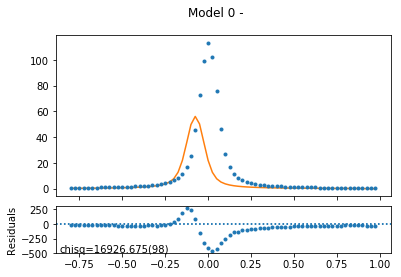

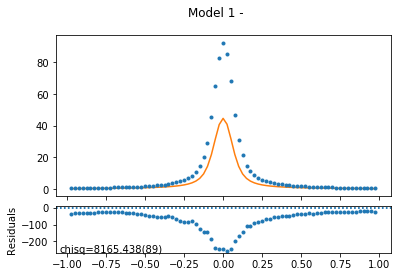

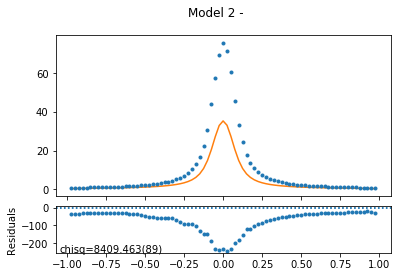

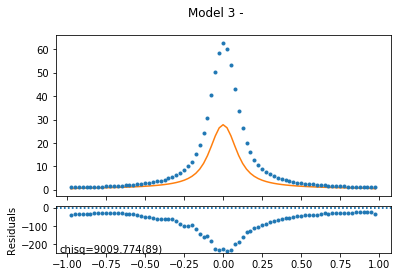

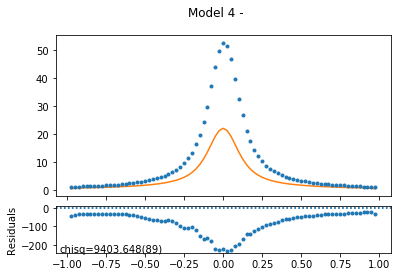

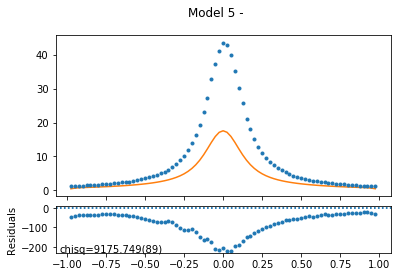

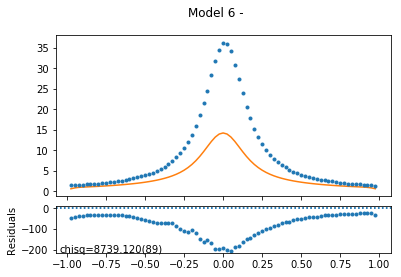

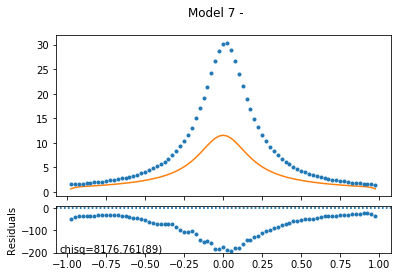

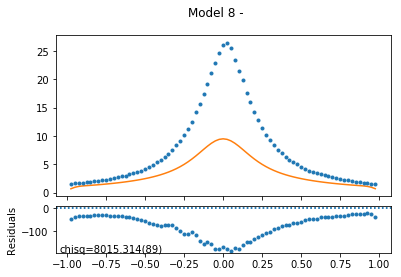

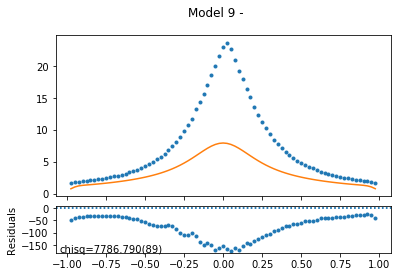

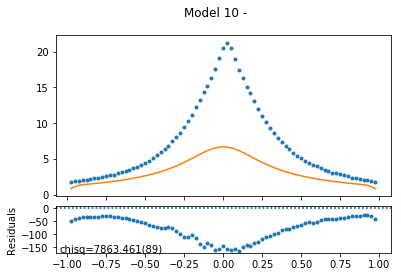

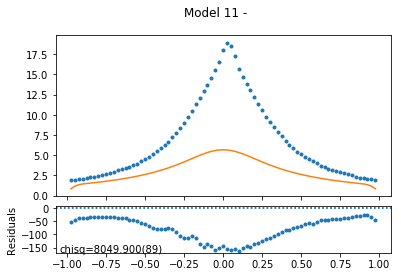

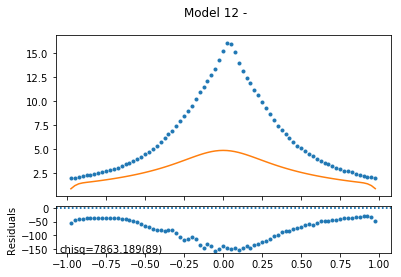

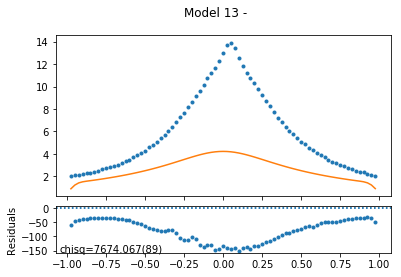

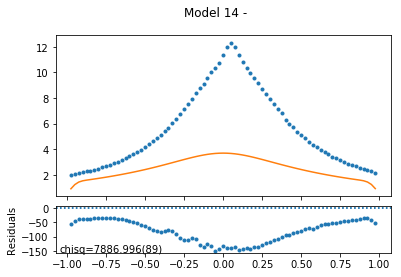

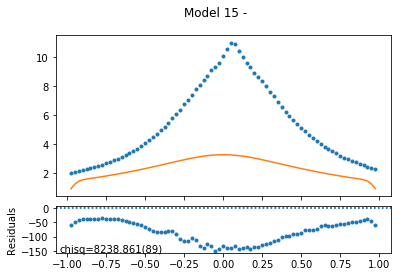

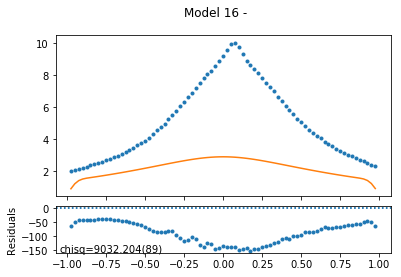

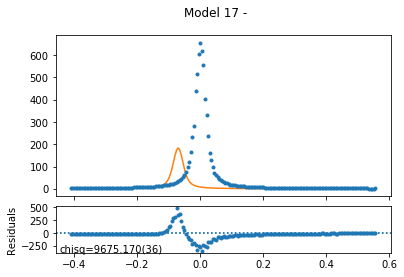

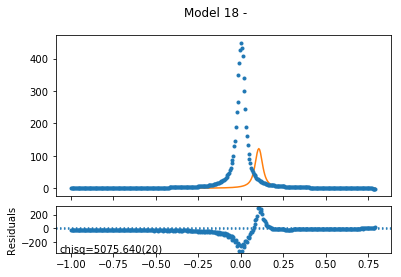

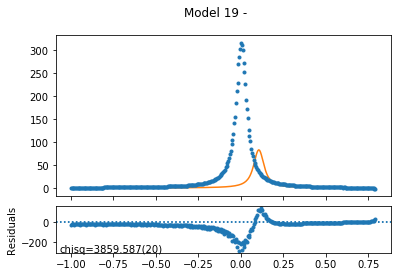

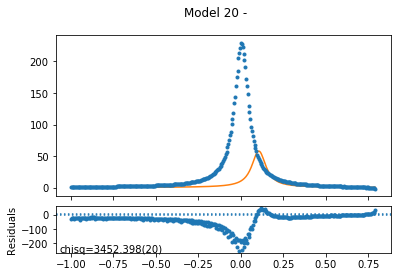

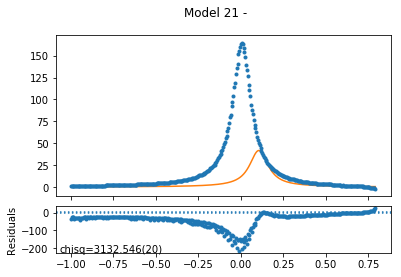

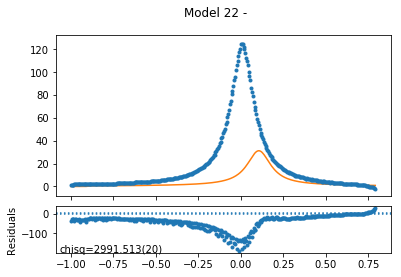

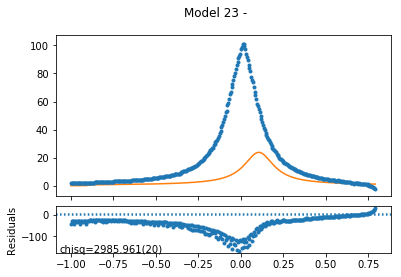

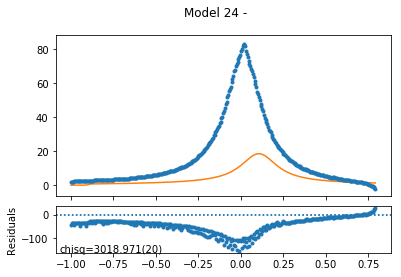

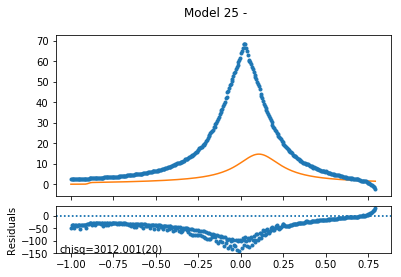

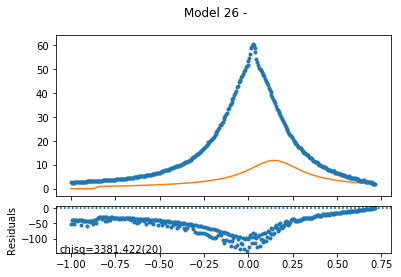

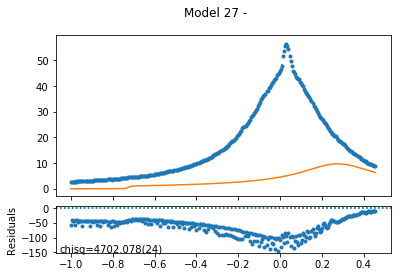

In [15]:
problem.plot()

In [16]:
problem.show()

-- Model 0 
.D = 0.13 in [0.05,0.25]
.DR = 0.3 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 0.5
.radius = 1 in [0.9,1.1]
.resTime = 0.1 in [0,1]
.scale = 10 in [0,100]

[chisq=16926.675(98), nllf=609360]
-- Model 1 
.D = 0.13 in [0.05,0.25]
.DR = 0.3 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 0.6
.radius = 1 in [0.9,1.1]
.resTime = 0.1 in [0,1]
.scale = 10 in [0,100]

[chisq=8165.438(89), nllf=322535]
-- Model 2 
.D = 0.13 in [0.05,0.25]
.DR = 0.3 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 0.7
.radius = 1 in [0.9,1.1]
.resTime = 0.1 in [0,1]
.scale = 10 in [0,100]

[chisq=8409.463(89), nllf=332174]
-- Model 3 
.D = 0.13 in [0.05,0.25]
.DR = 0.3 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 0.8
.radius = 1 in [0.9,1.1]
.resTime = 0.1 in [0,1]
.scale = 10 in [0,100]

[chisq=9009.774(89), nllf=355886]
-- Model 4 
.D = 0.13 in [0.05,0.25]
.DR = 0.3 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 0.9
.radius = 1 in [0.9,1.1]
.resTime = 0.1 in [0,1]
.scale = 10 in [0,100]

[chisq=9403.648(89), nllf=371444]
-- Model 

(<a href='#Table of Contents'>Top</a>)<a id='run_fit'></a><h2>Running the fit</h2>

Run the fit using the *minimizer* defined above with a number of *steps* also specified above.

In [17]:
result = fit(problem, 
             method=chosen_minimizer, 
             steps=steps, 
             verbose=True)

final chisq 4304.804(13)
=== Uncertainty est. from curvature: par    dx           dx/sqrt(chisq) ===
                                       D 0.12996(17)     0.1299640(25)  
                                      DR 0.1875(17)      0.187511(26)   
                                  center 0.003295(86)    0.0032952(13)  
                                  radius 0.9000(31)      0.900000(47)   
                                 resTime 0.4738(72)      0.47384(11)    
                                   scale 9.947(12)       9.94742(18)    
                                  center -0.00(10)e9     -0.0(15)e6     
                                   scale 10.873(13)      10.87320(21)   
                                  center -0.00(10)e9     -0.0(15)e6     
                                   scale 10.885(14)      10.88524(21)   
                                  center 0.07(12)e-3     66.6(18)e-6    
                                   scale 10.912(14)      10.91169(21)   
                       

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>

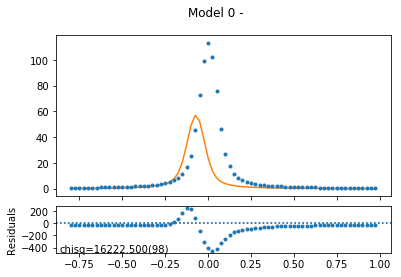

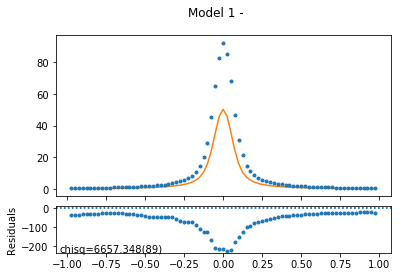

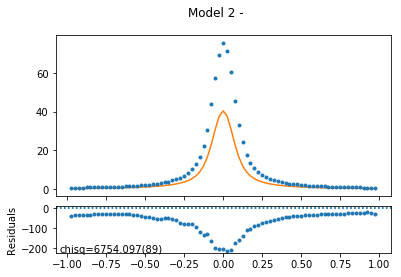

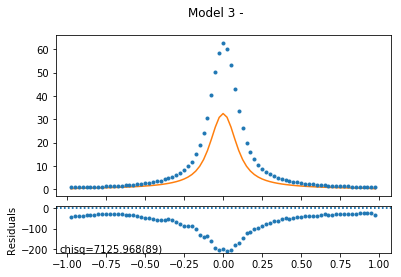

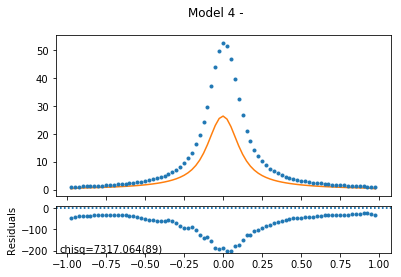

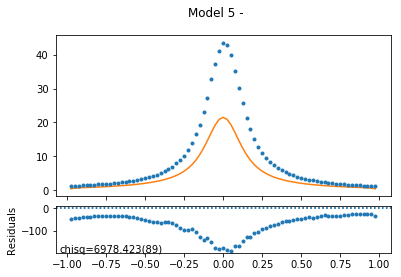

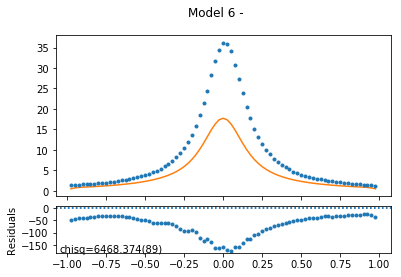

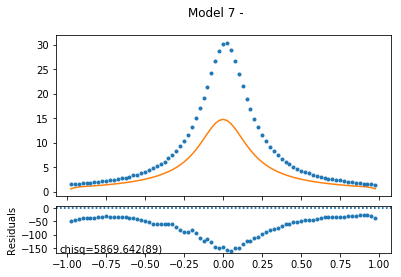

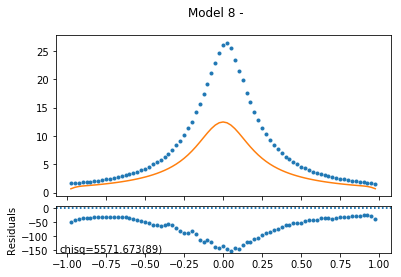

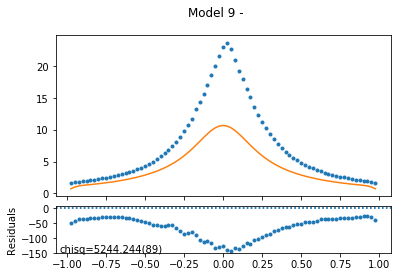

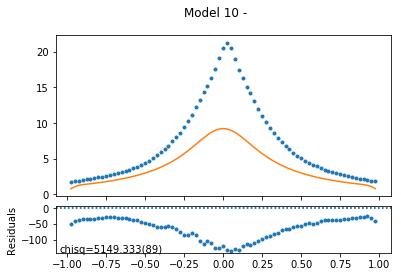

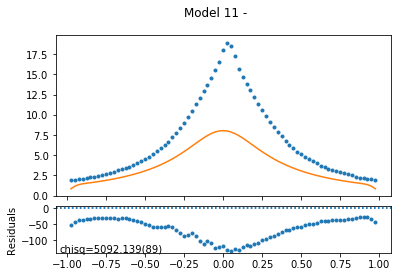

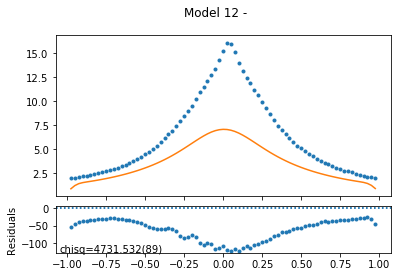

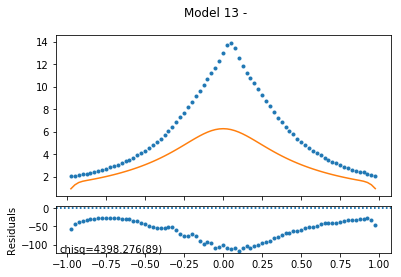

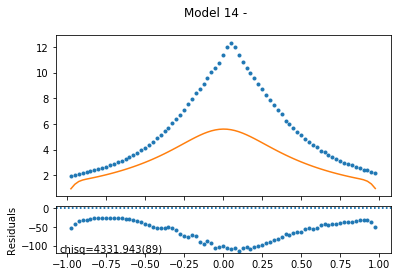

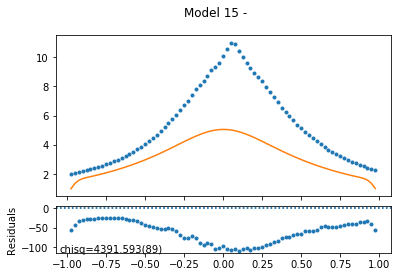

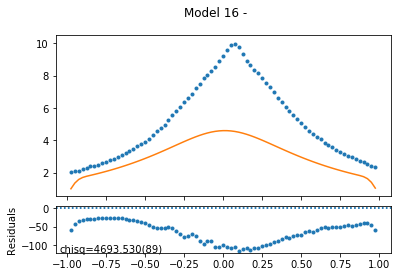

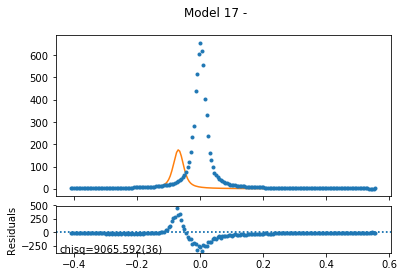

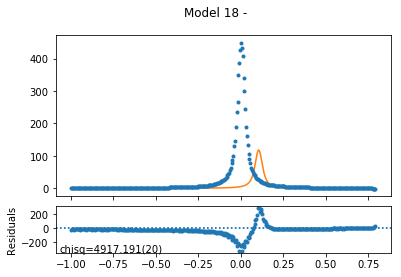

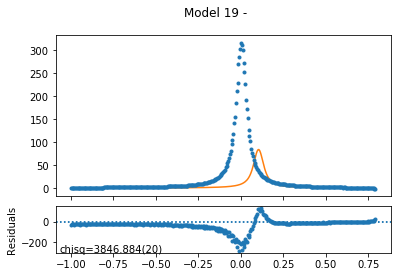

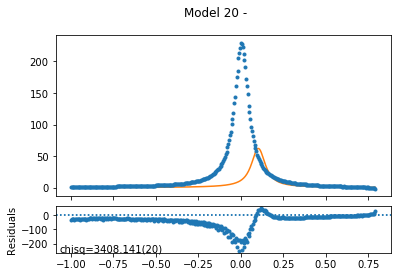

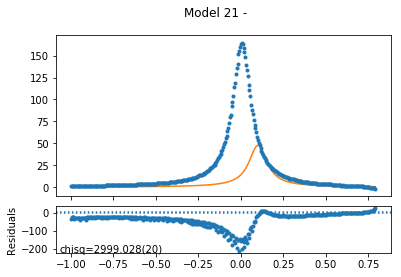

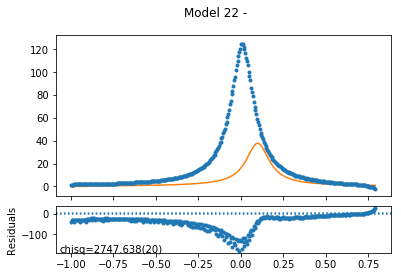

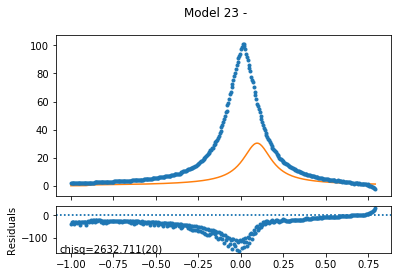

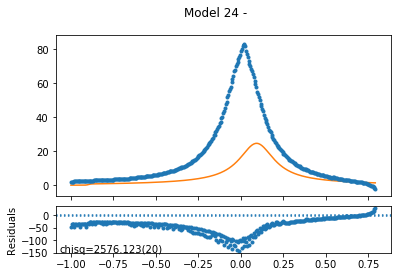

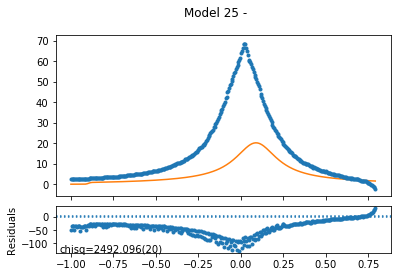

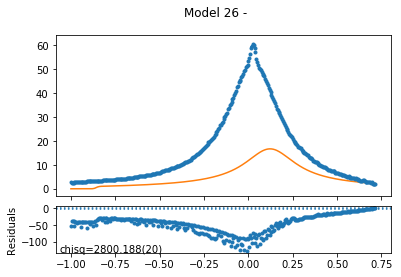

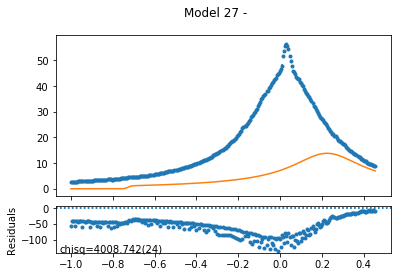

In [18]:
problem.plot()

In [19]:
# Display fitting results
problem.show()

-- Model 0 
.D = 0.129964 in [0.05,0.25]
.DR = 0.187511 in [0,1]
.center = 0.00329523 in [-0.1,0.1]
.q = 0.5
.radius = 0.9 in [0.9,1.1]
.resTime = 0.473835 in [0,1]
.scale = 9.94742 in [0,100]

[chisq=16222.500(98), nllf=584010]
-- Model 1 
.D = 0.129964 in [0.05,0.25]
.DR = 0.187511 in [0,1]
.center = -2.14046e-06 in [-0.1,0.1]
.q = 0.6
.radius = 0.9 in [0.9,1.1]
.resTime = 0.473835 in [0,1]
.scale = 10.8732 in [0,100]

[chisq=6657.348(89), nllf=262965]
-- Model 2 
.D = 0.129964 in [0.05,0.25]
.DR = 0.187511 in [0,1]
.center = -2.99864e-06 in [-0.1,0.1]
.q = 0.7
.radius = 0.9 in [0.9,1.1]
.resTime = 0.473835 in [0,1]
.scale = 10.8852 in [0,100]

[chisq=6754.097(89), nllf=266787]
-- Model 3 
.D = 0.129964 in [0.05,0.25]
.DR = 0.187511 in [0,1]
.center = 6.65811e-05 in [-0.1,0.1]
.q = 0.8
.radius = 0.9 in [0.9,1.1]
.resTime = 0.473835 in [0,1]
.scale = 10.9117 in [0,100]

[chisq=7125.968(89), nllf=281476]
-- Model 4 
.D = 0.129964 in [0.05,0.25]
.DR = 0.187511 in [0,1]
.center = -0.0018

In [20]:
# Print chi**2 and parameters' values after fit
print("final chisq", problem.chisq_str())
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    if k in dict_physical_units.keys():
        print(k, ":", format_uncertainty(v, dv), dict_physical_units[k])
    else:
        print(k, ":", format_uncertainty(v, dv))

final chisq 4304.804(13)
D : 0.12996(17)
DR : 0.1875(17)
center : 0.003295(86)
radius : 0.9000(31)
resTime : 0.4738(72)
scale : 9.947(12)
center : -0.00(10)e9
scale : 10.873(13)
center : -0.00(10)e9
scale : 10.885(14)
center : 0.07(12)e-3
scale : 10.912(14)
center : -0.00181(21)
scale : 10.927(14)
center : 0.08(21)e-3
scale : 10.907(14)
center : 0.00(10)e9
scale : 10.872(14)
center : -0.75(36)e-3
scale : 10.825(14)
center : -0.30(37)e-3
scale : 10.797(14)
center : 0.19(34)e-3
scale : 10.777(15)
center : 0.21(61)e-3
scale : 10.775(15)
center : -0.63(57)e-3
scale : 10.772(15)
center : 0.00474(70)
scale : 10.747(15)
center : 0.00(10)e9
scale : 10.718(15)
center : 0.00334(86)
scale : 10.716(16)
center : 0.00169(91)
scale : 10.724(16)
center : 10.0(10)e-3
scale : 10.748(16)
center : 642(24)e-6
scale : 9.4337(94)
center : -769(37)e-6
scale : 9.491(11)
center : -0.001580(76)
scale : 9.819(15)
center : -0.00289(14)
scale : 10.286(20)
center : -0.00471(21)
scale : 10.761(24)
center : -0.00687(2